# Interpolación de banda limitada para el tipo de cambio del dólar
© 2018 [Juan M. Fonseca-Solís](https://cr.linkedin.com/in/juan-m-fonseca-solis)
- - - 
## Resumen

La reconstrucción de secuencias temporales continuas a partir de muestras tomadas discretamente es un problema que ha sido resuelto tradicionalmente usando el teorema de Nyquist. Este teorema establece que la frecuencia de muestreo debe ser el doble de la frecuencia máxima contenida en la señal original para evitar la pérdida de información. La reconstrucción &ndash;también llamada interpolación&ndash; se logra convolucionando un núcleo previamente definido y cada muestra poseída, luego se realiza una suma de todas las convoluciones. El problema se complica cuando se dispone de muestras tomadas a una frecuencia de muestreo irregular, donde, en lugar de frecuencia de muestreo, se habla de una _tasa de innovación_ (FIR, por sus siglas en inglés). En este caso existe un método llamado interpolación de banda limitada (BLI, por sus siglas en inglés) que utiliza las series de Fourier y el método de mínimos cuadrados para obtener una aproximación de la señal original. Este método realiza la suposición de que la señal a representar no tiene frecuencias altas. En este _notebook_ se explica con mayor detalle en qué consiste el método mencionado, y, para ejemplificarlo, se propone remuestrear la señal del tipo de cambio del dólar en Costa Rica ofrecida por el Banco Central de Costa Rica (BCCR) desde el 2014 hasta el 2018.

## Interpolación de banda limitada

Por definir...

## Consumo del servicio web del BCCR

Para consumir el servicio SOAP del BCCR elegimos la librería [Zolera Soap Infraestructure](http://pywebsvcs.sourceforge.net/zsi.html). A continuación, importamos los paquetes necesarios para usarla, entre otras utilidades. Como prerequisito, es necesario instalar la librería previamente usando la instrucción `sudo apt-get install python-zsi`.

In [112]:
import xml.etree.ElementTree as ET  # librería para leer el xml
from ZSI.ServiceProxy import ServiceProxy  # libería para consumir el servicio SOAP
import datetime
import numpy
import bli

La operación que queremos consumir se llama "ObtenerIndicadoresEconomicosXML" y según el WSDL del BCCR recibe cinco parámetros:
* **ID del indicador** (317, para el tipo de cambio de compra) [1]
* **Fecha inicial** (en formato dd/mm/yyy)
* **Fecha final** (igual que el anterior)
* **Nombre del usuario** (irrelevante, pues no afecta la operación)
* **Char Y/N** (comunica si se desea obtener un reporte detallado con subindicadores)

El resultado de la operación es un XML con la forma:

    <string><Datos_de_INGC011_CAT_INDICADORECONOMIC>
      <INGC011_CAT_INDICADORECONOMIC>
        <COD_INDICADORINTERNO>317</COD_INDICADORINTERNO>
        <DES_FECHA>2014-01-01T00:00:00-06:00</DES_FECHA>
        <NUM_VALOR>495.01000000</NUM_VALOR>
      </INGC011_CAT_INDICADORECONOMIC>
      (...)
    </Datos_de_INGC011_CAT_INDICADORECONOMIC></string>
    
El cual retorna un valor del tipo de cambio por día, fijando la frecuencia de muestreo en $f_s=1$ día. Para consumir el servicio y obtener un arreglo de entradas tipo `float` a partir del XML usamos el siguiente código:<sup>3</sup>

In [159]:
# creamos un proxy con los servicios del WSDL
URL_WSDL = ("http://indicadoreseconomicos.bccr.fi.cr/\
IndicadoresEconomicos/WebServices/wsIndicadoresEconomicos.asmx?WSDL")
servicio = ServiceProxy(URL_WSDL)

# obtenemos la fecha de hoy según explica https://www.saltycrane.com/blog/2008/06/how-to-get-current-date-and-time-in/
now = datetime.datetime.now()
fechaInicio = '%s/%s/%s' % (now.day, now.month, now.year-1)
fechaFinal = '%s/%s/%s' % (now.day, now.month, now.year)

# encontramos el valor de compra del dólar durante todo el 2014
dicc = servicio.ObtenerIndicadoresEconomicosXML(
	tcIndicador='317',
	tcFechaInicio=fechaInicio,
	tcFechaFinal=fechaFinal,
	tcNombre = 'test',
	tnSubNiveles = 'N')

# sacamos el XML que viene encapsulado en el diccionario
xml = dicc['ObtenerIndicadoresEconomicosXMLResult']
raiz = ET.fromstring(xml)

# almacenamos los valores de cambio en un arreglo
zo = []
for hijo in raiz:
	act = float(hijo[2].text)
	zo.append(act)

Dado que el método hace la suposición de que no hay frecuencias altas en la señal a representar, realizamos un filtrado pasabajas para suavizar la señal.

In [204]:
N = len(zo)
z = [0]*N
M=10
for n in range(M,N):
    z[n] = numpy.sum(zo[n-M:n])/M
z = z[M:N]
N = len(z)

Luego podemos graficar la señal obtenida usando el siguiente código: 

Populating the interactive namespace from numpy and matplotlib


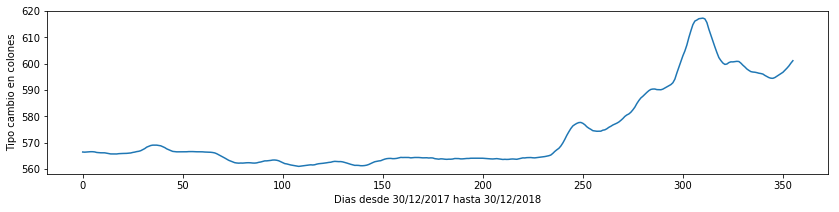

In [205]:
%pylab inline
%matplotlib inline

# graficamos los valores obtenidos
x = numpy.arange(N)  # eje de las ordenadas
pylab.rcParams['figure.figsize'] = (14.0, 3.0) # dimensiones del gráfico
pylab.plot(x,z)
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
pylab.show()

## Decimación aleatoria de la señal original

Para demostrar la utilidad de la BLI simulamos el caso en el que se cuenta con muestras tomadas a intervalos aleatorios. Para ello, iteramos por la señal original y conservamos cada entrada si el número aleatorio generado para ella es menor al valor $p$.

Text(0,0.5,'Tipo de cambio en colones')

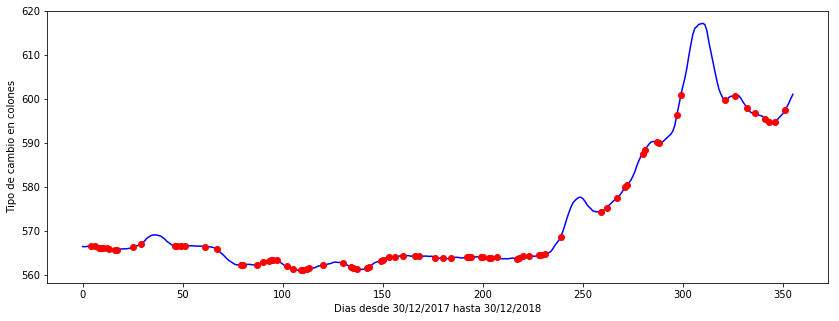

In [225]:
import random
p = 0.2 # probabilidad de conservar una muestra

xm = []
zm = []
for dia in range(len(x)):
    if random.random()<p:
        xm.append(x[dia])
        zm.append(z[dia])
    
# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 5.0) # dimensiones del gráfico
pylab.plot(x,z,'b-',xm,zm,'or') 
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo de cambio en colones')

Aquí vemos que la señal muestreada aleatoriamente aparece marcada con los puntos rojos sobre la señal original. Solo para demostrar que una interpolación con núcleo triangular, es decir, uniendo los puntos con una línea recta, no sirve, procedemos a correr el siguiente código de abajo. Se observa que muchas de los picos no han podido ser conservados, por lo que esta es una mala interpolación.

Text(0.5,1,'Mean squared error: 9.00')

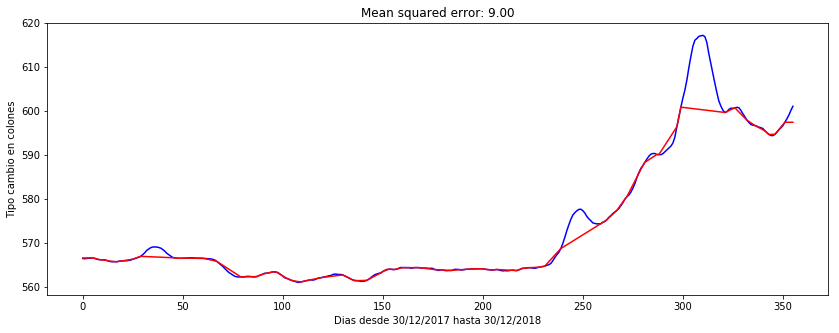

In [226]:
zm1 = numpy.interp(x, xm, zm, left=None, right=None, period=None)
pylab.plot(x,z,'b-',x,zm1,'r-')
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
error = numpy.mean(numpy.power(numpy.array(z)-numpy.array(zm1),2))
pylab.title('Mean squared error: %.2f' % error)

## Interpolación de banda limitada

Ahora usamos BLI para aproximar la señal original.<sup>4</sup>

Text(0.5,1,'Mean squared error: 447.35')

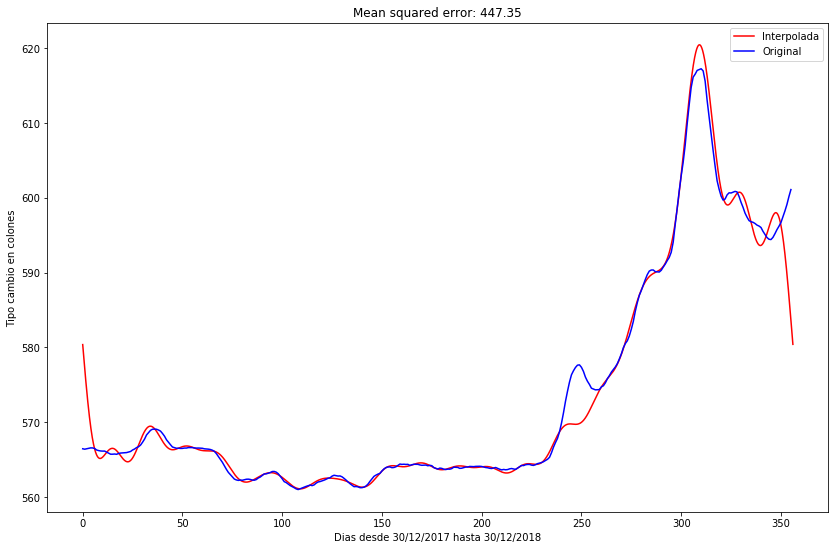

In [229]:
'''
Aplicamos la interpolación BL
'''
orden = 20 # número de coeficientes de la aproximación (empírico)
T = [0, N]
xmp = expand_dims(array(xm),1)
zmp = expand_dims(array(zm),1)

# calculamos la interpolación BL
zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, orden, win=False)

# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 9.0) # dimensiones del gráfico
plot(xp1, numpy.real(zp1), 'r', x, z, 'b')
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
legend(('Interpolada', 'Original','Medidas'))
error = numpy.mean(numpy.power(numpy.array(z)-numpy.real(zp1),2))
pylab.title('Mean squared error: %.2f' % error)

Donde, la BLI presenta un MSE mayor pero la cantidad de picos estimados más precisa. Si graficamos los coeficientes de Fourier obtenemos el siguiente gráfico:

Text(0.5,1,'Magnitud de los coeficientes de Fourier')

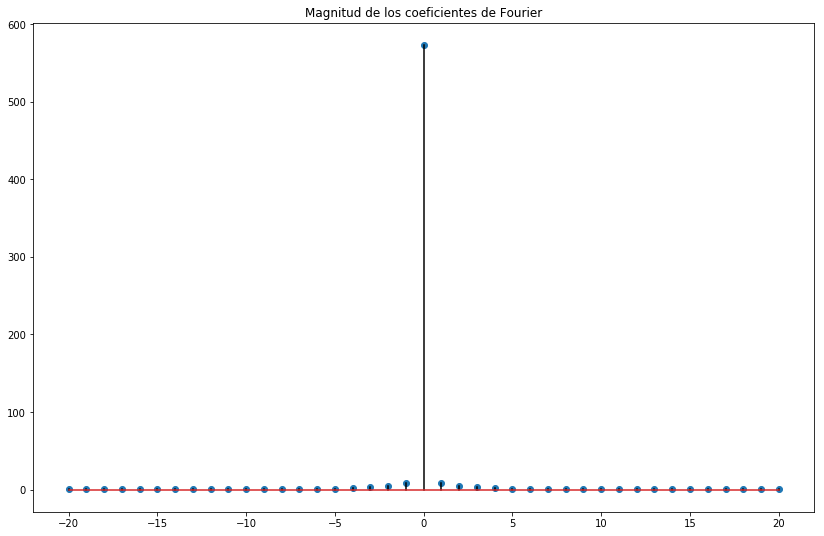

In [230]:
stem(k1.T, numpy.abs(C1), 'k')
title('Magnitud de los coeficientes de Fourier')

## Cantidad de coeficientes

Como la gráfica de los coeficientes es par, solo necesitamos almacenar la mitad de los coeficientes, es decir que podemos calcular el porcentaje de compresión de la siguiente manera:

$$\text{nc}=\frac{dim(\text{zm})-0.5 \, \text{orden}}{dim(\text{zm})}$$

In [231]:
nc = (len(zm)-(orden*0.5))/len(zm)
print 'Muestras tomadas: ',len(zm)
print 'Cantidad de coeficientes: ', orden/2, ' (necesarios para reproducir la señal)'
print 'Compresión lograda: ', int(nc*100),'%'

Muestras tomadas:  83
Cantidad de coeficientes:  10  (necesarios para reproducir la señal)
Compresión lograda:  87 %


## Referencias:

1. Banco Central de Costa Rica. **Catálogo de indicadores económicos disponibles a consultar**. URL: http://www.bccr.fi.cr/indicadores_economicos_/ServicioWeb.html. Última vez consultado: 04/11/15

* Ecolé Polytechnique Federale de Lausanne. **Band-limited interpolation of radiation measurements in Fukushima**.

## Notas
1. Decimación quiere decir reducir la tasa de muestreo de la señal, es decir reducir la cantidad de puntos que contiene la misma
* Un excelente recurso de cómo usar los servicios del BCCR también puede encontrarse en [Tico](https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica-y-ruby/)
* Para escribir este ipython notebook se usó la sintaxis [Markdown](https://help.github.com/articles/markdown-basics/) y un interpretador [XML](https://docs.python.org/2/library/xml.etree.elementtree.html). Aunque no fue usado, éste documento soporta $\LaTeX$
* Es importante destacar que el método BL no consiste solo en aplicar la transformada discreta de Fourier, sino también en reconstruir la señal a partir de los coeficientes obtenidos para los puntos que no forman parte del muestreo original

---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="img/80x15_by-nd.png" /></a><br />Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">licencia de Creative Commons Reconocimiento-SinObraDerivada 4.0 Internacional</a>.